# Navigation

---

In this notebook, you will learn how to use the Unity ML-Agents environment for the first project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893).

### 1. Start the Environment

We begin by importing some necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
import os
from unityagents import UnityEnvironment
import numpy as np
import torch
print('PyTorch Version:', torch.__version__)
from torchsummary import summary
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline
plt.ion()

PyTorch Version: 1.0.0


Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Banana.app"`
- **Windows** (x86): `"path/to/Banana_Windows_x86/Banana.exe"`
- **Windows** (x86_64): `"path/to/Banana_Windows_x86_64/Banana.exe"`
- **Linux** (x86): `"path/to/Banana_Linux/Banana.x86"`
- **Linux** (x86_64): `"path/to/Banana_Linux/Banana.x86_64"`
- **Linux** (x86, headless): `"path/to/Banana_Linux_NoVis/Banana.x86"`
- **Linux** (x86_64, headless): `"path/to/Banana_Linux_NoVis/Banana.x86_64"`

For instance, if you are using a Mac, then you downloaded `Banana.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Banana.app")
```

In [2]:
env = UnityEnvironment(file_name=os.path.normpath("./Banana_Linux_NoVis/Banana.x86_64"))

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

The simulation contains a single agent that navigates a large environment.  At each time step, it has four actions at its disposal:
- `0` - walk forward 
- `1` - walk backward
- `2` - turn left
- `3` - turn right

The state space has `37` dimensions and contains the agent's velocity, along with ray-based perception of objects around agent's forward direction.  A reward of `+1` is provided for collecting a yellow banana, and a reward of `-1` is provided for collecting a blue banana. 

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents in the environment
print('Number of agents:', len(env_info.agents))

# number of actions
action_size = brain.vector_action_space_size
print('Number of actions:', action_size)

# examine the state space 
state = env_info.vector_observations[0]
print('States is of type:', type(state))
print('States look like:', state)
state_size = len(state)
print('States have length:', state_size)

Number of agents: 1
Number of actions: 4
States is of type: <class 'numpy.ndarray'>
States look like: [1.         0.         0.         0.         0.84408134 0.
 0.         1.         0.         0.0748472  0.         1.
 0.         0.         0.25755    1.         0.         0.
 0.         0.74177343 0.         1.         0.         0.
 0.25854847 0.         0.         1.         0.         0.09355672
 0.         1.         0.         0.         0.31969345 0.
 0.        ]
States have length: 37


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Once this cell is executed, you will watch the agent's performance, if it selects an action (uniformly) at random with each time step.  A window should pop up that allows you to observe the agent, as it moves through the environment.  

Of course, as part of the project, you'll have to change the code so that the agent is able to use its experience to gradually choose better actions when interacting with the environment!

In [5]:
# test the untrained agent for n_test times
n_test = 20
score_list = []
for _ in range(n_test):
    env_info = env.reset(train_mode=False)[brain_name] # reset the environment
    state = env_info.vector_observations[0]            # get the current state
    score = 0                                          # initialize the score
    while True:
        action = np.random.randint(action_size)        # select an action
        env_info = env.step(action)[brain_name]        # send the action to the environment
        next_state = env_info.vector_observations[0]   # get the next state
        reward = env_info.rewards[0]                   # get the reward
        done = env_info.local_done[0]                  # see if episode has finished
        state = next_state                             # roll over the state to next time step
        score += reward                                # update the score
        if done:                                       # exit loop if episode finished
            break
    score_list.append(score)

print("Average score (random actions): {}".format(np.mean(score_list)))

Average score (random actions): -0.2


When finished, you can close the environment.
```python
env.close()
```

### 4. Define the agent training function

In [6]:
def train_dqn(env, agent, save_model, n_episodes=2000,
              eps_start=1.0, eps_end=0.01, eps_decay=0.995,
              deque_len=100, print_every=100, finish_threshold=13.0):
    """Deep Q-Learning.
    
    Params
    ======
        env: environment
        agent: deep Q-learning agent
        save_model: model filename for saving
        n_episodes (int): maximum number of training episodes
        eps_start (float): starting value of epsilon, for epsilon-greedy action selection
        eps_end (float): minimum value of epsilon
        eps_decay (float): multiplicative factor (per episode) for decreasing epsilon
        deque_len (int): length of score deque
        print_every (int): print a new line of scores after such number of episodes
        finish_threshold (float): the training process will finish if the average score is larger than such threshold
    """
    scores_deque = deque(maxlen=deque_len)  # deque containing last deque_len scores to calculate moving average scores
    scores = []                             # list containing scores from each episode
    scores_movingmean = []                  # list containing moving average scores
    eps = eps_start                         # initialize epsilon
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name]
        state = env_info.vector_observations[0]
        score = 0
        step = 0
        while True:
            step += 1
            action = agent.act(state, eps)
            env_info = env.step(action)[brain_name]  # send the action to the environment
            next_state = env_info.vector_observations[0]  # get the next state
            reward = env_info.rewards[0]  # get the reward
            done = env_info.local_done[0]  # see if episode has finished
            agent.step(state, action, reward, next_state, done)
            state = next_state
            score += reward
            if done:
                break 
        scores.append(score)            # save most recent score
        scores_deque.append(score)      # save most recent score
        scores_movingmean.append(np.mean(scores_deque))
        eps = max(eps_end, eps_decay*eps) # decrease epsilon
        print('\rEpisode {}\tMoving average score: {:.2f}\tCurrent score: {}'.format(i_episode, scores_movingmean[-1], score), end="")
        if i_episode % print_every == 0:
            print('\rEpisode {}\tMoving average score: {:.2f}\tCurrent score: {}'.format(i_episode, scores_movingmean[-1], score))
        if scores_movingmean[-1] >= finish_threshold:  # save the model
            print('\nEnvironment solved in {:d} episodes!\tMoving average score: {:.2f}'.format(i_episode-deque_len, scores_movingmean[-1]))
            torch.save(agent.qnetwork_local.state_dict(), save_model)
            break
    return scores, scores_movingmean

### 5. Deep Q-learning

#### 5.1. Train the agent

In [7]:
from agent_dqn import Agent

# deep Q-learning agent
agent_dqn = Agent(state_size, action_size, seed=0, use_double=False, use_dueling=False, use_per=False)
summary(agent_dqn.qnetwork_local, (state_size,))  # print the network summary

scores_dqn, scores_dqn_movingmean = train_dqn(env, agent_dqn, 'model_dqn.pt', finish_threshold=15.0)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 128]           4,864
       BatchNorm1d-2                  [-1, 128]             256
              ReLU-3                  [-1, 128]               0
            Linear-4                   [-1, 64]           8,256
       BatchNorm1d-5                   [-1, 64]             128
              ReLU-6                   [-1, 64]               0
            Linear-7                   [-1, 32]           2,080
              ReLU-8                   [-1, 32]               0
            Linear-9                    [-1, 4]             132
Total params: 15,716
Trainable params: 15,716
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.06
Estimated Total Size (MB): 0.07
---------------------------------------------

#### 5.2. Plot the training score curve

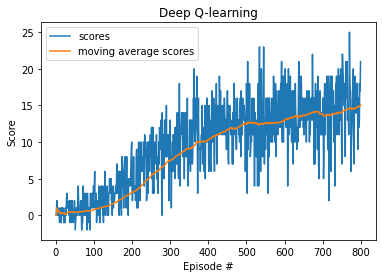

In [8]:
plt.figure()
plt.plot(np.arange(1, len(scores_dqn)+1), scores_dqn,
         label='scores')
plt.plot(np.arange(1, len(scores_dqn_movingmean)+1), scores_dqn_movingmean,
         label='moving average scores')
plt.legend()
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.title('Deep Q-learning')
plt.show()

#### 5.3. Test the trained deep Q-learning agent

In [9]:
# load the weights from the saved checkpoint file
agent_dqn.qnetwork_local.load_state_dict(torch.load('model_dqn.pt'))

# test the trained agent for n_test times
n_test = 20
score_dqn_list = []
for _ in range(n_test):
    env_info = env.reset(train_mode=False)[brain_name]
    state = env_info.vector_observations[0]
    score = 0
    while True:
        action = agent_dqn.act(state)
        env_info = env.step(action)[brain_name]
        next_state = env_info.vector_observations[0]
        reward = env_info.rewards[0]
        done = env_info.local_done[0]
        state = next_state
        score += reward
        if done:
            break
    score_dqn_list.append(score)

print("Average score (after deep Q-learning): {}".format(np.mean(score_dqn_list)))

Average score (after deep Q-learning): 9.85


### 6. Double deep Q-learning

#### 6.1. Train the agent

In [10]:
# double deep Q-learning agent
agent_doubledqn = Agent(state_size, action_size, seed=0, use_double=True, use_dueling=False, use_per=False)
summary(agent_doubledqn.qnetwork_local, (state_size,))  # print the network summary

scores_doubledqn, scores_doubledqn_movingmean = train_dqn(env, agent_doubledqn, 'model_doubledqn.pt', finish_threshold=15.0)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 128]           4,864
       BatchNorm1d-2                  [-1, 128]             256
              ReLU-3                  [-1, 128]               0
            Linear-4                   [-1, 64]           8,256
       BatchNorm1d-5                   [-1, 64]             128
              ReLU-6                   [-1, 64]               0
            Linear-7                   [-1, 32]           2,080
              ReLU-8                   [-1, 32]               0
            Linear-9                    [-1, 4]             132
Total params: 15,716
Trainable params: 15,716
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.06
Estimated Total Size (MB): 0.07
---------------------------------------------

#### 6.2. Plot the training score curve

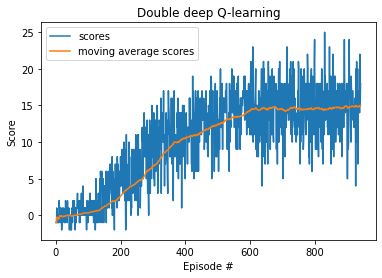

In [11]:
plt.figure()
plt.plot(np.arange(1, len(scores_doubledqn)+1), scores_doubledqn,
         label='scores')
plt.plot(np.arange(1, len(scores_doubledqn_movingmean)+1), scores_doubledqn_movingmean,
         label='moving average scores')
plt.legend()
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.title('Double deep Q-learning')
plt.show()

#### 6.3. Test the trained double deep Q-learning agent

In [12]:
# load the weights from the saved checkpoint file
agent_doubledqn.qnetwork_local.load_state_dict(torch.load('model_doubledqn.pt'))

# test the trained agent for n_test times
n_test = 20
score_doubledqn_list = []
for _ in range(n_test):
    env_info = env.reset(train_mode=False)[brain_name]
    state = env_info.vector_observations[0]
    score = 0  # initialize the score
    while True:
        action = agent_doubledqn.act(state)
        env_info = env.step(action)[brain_name]
        next_state = env_info.vector_observations[0]
        reward = env_info.rewards[0]
        done = env_info.local_done[0]
        state = next_state
        score += reward
        if done:
            break
    score_doubledqn_list.append(score)

print("Average score (after double deep Q-learning): {}".format(np.mean(score_doubledqn_list)))

Average score (after double deep Q-learning): 15.0


### 7. Dueling deep Q-learning

#### 7.1. Train the agent

In [13]:
# dueling deep Q-learning agent
agent_duelingdqn = Agent(state_size, action_size, seed=0, use_double=False, use_dueling=True, use_per=False)
summary(agent_duelingdqn.qnetwork_local, (state_size,))  # print the network summary

scores_duelingdqn, scores_duelingdqn_movingmean = train_dqn(env, agent_duelingdqn, 'model_duelingdqn.pt', finish_threshold=15.0)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 128]           4,864
       BatchNorm1d-2                  [-1, 128]             256
              ReLU-3                  [-1, 128]               0
            Linear-4                   [-1, 64]           8,256
       BatchNorm1d-5                   [-1, 64]             128
              ReLU-6                   [-1, 64]               0
            Linear-7                   [-1, 32]           2,080
              ReLU-8                   [-1, 32]               0
            Linear-9                    [-1, 1]              33
           Linear-10                   [-1, 32]           2,080
             ReLU-11                   [-1, 32]               0
           Linear-12                    [-1, 4]             132
Total params: 17,829
Trainable params: 17,829
Non-trainable params: 0
---------------------------------

#### 7.2. Plot the training score curve

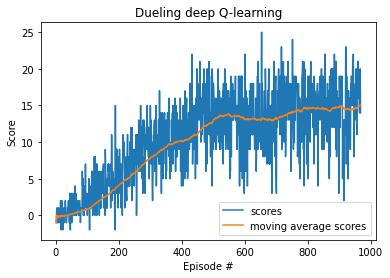

In [14]:
plt.figure()
plt.plot(np.arange(1, len(scores_duelingdqn)+1), scores_duelingdqn,
         label='scores')
plt.plot(np.arange(1, len(scores_duelingdqn_movingmean)+1), scores_duelingdqn_movingmean,
         label='moving average scores')
plt.legend()
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.title('Dueling deep Q-learning')
plt.show()

#### 7.3. Test the trained dueling deep Q-learning agent

In [15]:
# load the weights from the saved checkpoint file
agent_duelingdqn.qnetwork_local.load_state_dict(torch.load('model_duelingdqn.pt'))

# test the trained agent for n_test times
n_test = 20
score_duelingdqn_list = []
for _ in range(n_test):
    env_info = env.reset(train_mode=False)[brain_name]
    state = env_info.vector_observations[0]
    score = 0  # initialize the score
    while True:
        action = agent_duelingdqn.act(state)
        env_info = env.step(action)[brain_name]
        next_state = env_info.vector_observations[0]
        reward = env_info.rewards[0]
        done = env_info.local_done[0]
        state = next_state
        score += reward
        if done:
            break
    score_duelingdqn_list.append(score)

print("Average score (after dueling deep Q-learning): {}".format(np.mean(score_duelingdqn_list)))

Average score (after dueling deep Q-learning): 15.55


### 8. Double deep Q-learning with Prioritized Experience Replay (PER)

#### 8.1. Train the agent

In [16]:
# double deep Q-learning agent with PER
agent_doubledqnper = Agent(state_size, action_size, seed=0, use_double=True, use_dueling=False, use_per=True)
summary(agent_doubledqnper.qnetwork_local, (state_size,))  # print the network summary

scores_doubledqnper, scores_doubledqnper_movingmean = train_dqn(env, agent_doubledqnper, 'model_doubledqnper.pt', finish_threshold=15.0)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 128]           4,864
       BatchNorm1d-2                  [-1, 128]             256
              ReLU-3                  [-1, 128]               0
            Linear-4                   [-1, 64]           8,256
       BatchNorm1d-5                   [-1, 64]             128
              ReLU-6                   [-1, 64]               0
            Linear-7                   [-1, 32]           2,080
              ReLU-8                   [-1, 32]               0
            Linear-9                    [-1, 4]             132
Total params: 15,716
Trainable params: 15,716
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.06
Estimated Total Size (MB): 0.07
---------------------------------------------

#### 8.2. Plot the training score curve

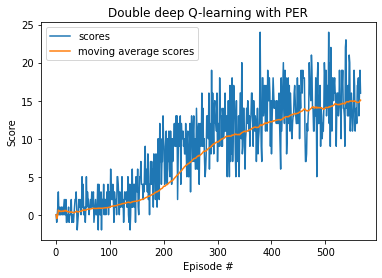

In [17]:
plt.figure()
plt.plot(np.arange(1, len(scores_doubledqnper)+1), scores_doubledqnper,
         label='scores')
plt.plot(np.arange(1, len(scores_doubledqnper_movingmean)+1), scores_doubledqnper_movingmean,
         label='moving average scores')
plt.legend()
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.title('Double deep Q-learning with PER')
plt.show()

#### 8.3. Test the trained double deep Q-learning agent with PER

In [18]:
# load the weights from the saved checkpoint file
agent_doubledqnper.qnetwork_local.load_state_dict(torch.load('model_doubledqnper.pt'))

# test the trained agent for n_test times
n_test = 20
score_doubledqnper_list = []
for _ in range(n_test):
    env_info = env.reset(train_mode=False)[brain_name]
    state = env_info.vector_observations[0]
    score = 0  # initialize the score
    while True:
        action = agent_doubledqnper.act(state)
        env_info = env.step(action)[brain_name]
        next_state = env_info.vector_observations[0]
        reward = env_info.rewards[0]
        done = env_info.local_done[0]
        state = next_state
        score += reward
        if done:
            break
    score_doubledqnper_list.append(score)

print("Average score (after double deep Q-learning with PER): {}".format(np.mean(score_doubledqnper_list)))

Average score (after double deep Q-learning with PER): 14.1


### 9. Comparing the running mean score curves

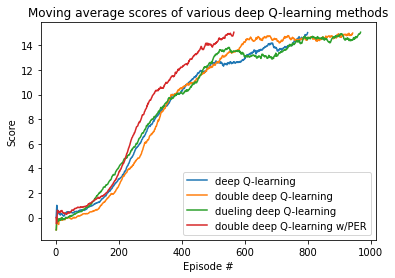

In [19]:
plt.figure()
plt.plot(np.arange(1, len(scores_dqn_movingmean)+1), scores_dqn_movingmean,
         label='deep Q-learning')
plt.plot(np.arange(1, len(scores_doubledqn_movingmean)+1), scores_doubledqn_movingmean,
         label='double deep Q-learning')
plt.plot(np.arange(1, len(scores_duelingdqn_movingmean)+1), scores_duelingdqn_movingmean,
         label='dueling deep Q-learning')
plt.plot(np.arange(1, len(scores_doubledqnper_movingmean)+1), scores_doubledqnper_movingmean,
         label='double deep Q-learning w/PER')
plt.legend()
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.title('Moving average scores of various deep Q-learning methods')
plt.show()

### 10. Close the environment

In [20]:
env.close()